In [65]:
import sys, os, h5py, warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal, ndimage, stats, interpolate

import py21cmfast as p21c
from py21cmfast import plotting
from py21cmfast import cache_tools
cache_tools.clear_cache()

sys.path.append('../XRay_Development/')
from field_smoother import WindowedData

# We change the default level of the logger so that
# we can see what's happening with caching.
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)
%matplotlib inline

2023-06-08 14:36:48,150 | INFO | Removed 0 files from cache.


In [66]:
from astropy.cosmology import Planck18 as cosmo

# Configure the Run

### Basic 21cmFAST Config

In [67]:
N_THREADS = 1
cosmo_params_EMF = dict(OMm=0.32, OMb=0.049, POWER_INDEX=0.96, SIGMA_8=0.83, hlittle=0.67)

In [68]:
# This method gets the evaluation redshifts from 21cmFAST
def get_z_arr(z_start=None, z_end=5):
    
    if z_start is None:
        z_start = p21c.global_params.Z_HEAT_MAX
    z_arr = [z_end]
    while np.max(z_arr) < z_start:
        z_prev = (1 + np.max(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
        z_arr.append(z_prev)
    return np.array(z_arr[::-1][1:])

z_evals = get_z_arr(z_end = 5)

In [69]:
init_box = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM=50, # [1]
        BOX_LEN=50, # [p-Mpc]
        N_THREADS=N_THREADS
    ),
    cosmo_params = p21c.CosmoParams(**cosmo_params_EMF),
    random_seed=54321, write=True
)

/global/scratch/projects/pc_heptheory/fosterjw/miniconda3/envs/21cmfast/lib/python3.11/site-packages/py21cmfast/inputs.py:485: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


### Dark History Config

In [70]:
# X-Ray Spectrum Bins
ex_lo = .1 # keV
ex_hi = 10 # keV
n_xbins = 10

x_bin_edges = np.geomspace(ex_lo, ex_hi, n_xbins+1)
x_bin_centers = (x_bin_edges[1:] + x_bin_edges[:-1]) / 2

# Global Bath Bins
eb_hi = 100e6 # keV
n_bbins = 100

g_bin_edges = np.geomspace(ex_hi, eb_hi, n_bbins+1)
b_bin_centers = (g_bin_edges[1:] + g_bin_edges[:-1]) / 2

### Instantiate the Field Smoother Object

In [71]:
field_path = './Smoothed_Fields.h5'
if os.path.isfile(field_path):
    os.remove(field_path)

dx = init_box.user_params.BOX_LEN / init_box.user_params.HII_DIM
N = init_box.user_params.HII_DIM
windowed_data = WindowedData(field_path,  N, dx, n_xbins)

# Start by Generating the Initial Conditions from 21cmFAST

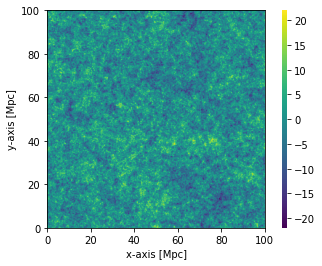

In [72]:
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 100, "BOX_LEN": 100},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321
)
plotting.coeval_sliceplot(initial_conditions, "hires_density");

# Take the first 21cmFAST Step

Here we take the first 21cm fast step so that we at a redshift later that the `Z_HEAT_MAX` redshift set in 21cmFAST

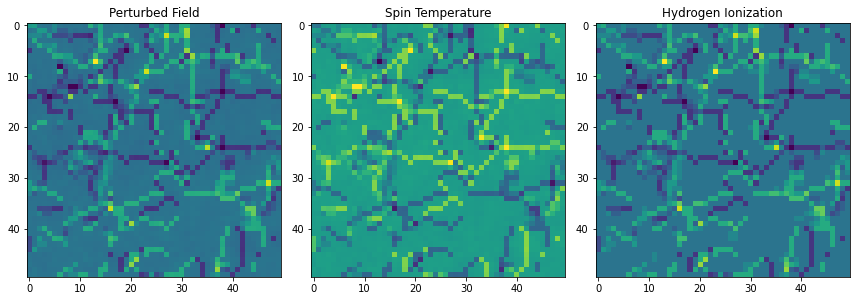

In [29]:
zindex =0

perturbed_field = p21c.perturb_field(redshift = z_evals[zindex], init_boxes = initial_conditions)
spin_temp = p21c.spin_temperature(perturbed_field = perturbed_field)
ionized_field = p21c.ionize_box(spin_temp = spin_temp)
brightness_temp = p21c.brightness_temperature(spin_temp = spin_temp, ionized_box=ionized_field, perturbed_field=perturbed_field)

fig, axs = plt.subplots(ncols = 3, figsize = (12, 4))

axs[0].imshow(perturbed_field.density[0])
axs[1].imshow(spin_temp.Ts_box[0])
axs[2].imshow(ionized_field.xH_box[0])

axs[0].set_title('Perturbed Field')
axs[1].set_title('Spin Temperature')
axs[2].set_title('Hydrogen Ionization')

plt.tight_layout()

### Synchronize the 21cmFAST state with the Dark History State

In [30]:
# Replace these with their true values from Dark History
dh_xe_global = np.mean(spin_temp.x_e_box)
dh_tk_global = np.mean(spin_temp.Tk_box)

spin_temp.x_e_box +=  dh_xe_global - np.mean(spin_temp.x_e_box)
spin_temp.Tk_box +=  dh_tk_global - np.mean(spin_temp.Tk_box)

# Here after, the run 21cmFAST evolution with box injection

### Generate 21cm Injection Boxes and Container Spectrum

In [35]:
zindex = 1

In [38]:
#input_heating = p21c.input_heating(redshift = z_evals[zindex], init_boxes = initial_conditions, write = False)
#input_ionization = p21c.input_ionization(redshift = z_evals[zindex], init_boxes = initial_conditions, write = False)
#input_jalpha = p21c.input_jalpha(redshift = z_evals[zindex], init_boxes = initial_conditions, write = False)

phot_xray_spec = np.zeros((n_xbins)) # The global average of the x-ray spectrum
phot_xray_box = np.zeros_like(spin_temp.Tk_box) # The local x-ray brightness parameter 
phot_bath_spec = np.zeros((n_bbins)) # The globally averaged homogeneous bath spectrum

### On the Spot and Global Bath Injection

In [39]:
def OTS_Dummy(*kwargs):
    return np.ones((n_xbins)), np.ones((n_bbins)), 0, 0, 0

def Bath_Dummy(*kwargs):
    return np.ones((n_xbins)), np.ones((n_bbins)), 0, 0, 0

def XRay_Dummy(*kwargs):
    return np.ones((n_xbins)), np.ones((n_bbins)), 0, 0, 0

In [ ]:
# Looping over 
for i in range(init_box.user_params.HII_DIM):
    for j in range(init_box.user_params.HII_DIM):
        for k in range(init_box.user_params.HII_DIM):
            
            #################################
            ###   On the Spot Injection   ###
            #################################
            
            pix_phot_xray_spec, pix_phot_bath_spec, pix_heating, pix_ionization, pix_jalpha = OTS_Dummy()
            
            # Add photon spectrum to global spectrum register
            phot_xray_spec += pix_phot_xray_spec
            phot_bath_spec += pix_phot_bath_spec

            # Record pixel quantities
            phot_xray_box[i, j, k] += np.sum(pix_phot_xray_spec)
            input_heating[i, j, k] += pix_heating
            input_ionization[i, j, k] += pix_ionization
            input_jalpha[i, j, k] += pix_jalpha
            
            ##################################
            ###   Global Bath  Injection   ###
            ##################################
            
            # Add photon spectrum to global spectrum register
            phot_xray_spec += pix_phot_xray_spec
            phot_bath_spec += pix_phot_bath_spec

            # Record pixel quantities
            phot_xray_box[i, j, k] += np.sum(pix_phot_xray_spec)
            input_heating[i, j, k] += pix_heating
            input_ionization[i, j, k] += pix_ionization
            input_jalpha[i, j, k] += pix_jalpha

### Propagating X-Ray Injection

In [57]:
def Calc_R(z_receiver, z1, z2):
    R1 = cosmo.lookback_distance(z1) - cosmo.lookback_distance(z_receiver)
    R2 = cosmo.lookback_distance(z2) - cosmo.lookback_distance(z_receiver)
    
    return R1.value, R2.value

def dVdz(z):
    return cosmo.differential_comoving_volume(10).value*4*np.pi

In [64]:
cosmo.lookback_distance(50).

<Quantity 4212.79869715 Mpc>

In [63]:
cosmo.lookback_distance(10)

<Quantity 4082.5418201 Mpc>

In [ ]:
def Calc_R(z_receiver, z_start, z_end):
    return 0, 1

def get_smoothed(z_receiver, z_start, z_end):
    return windowed_data.smoothed_shell(z_evals[zindex-1], *Calc_R(0, 0, 0))

In [ ]:
for shell_index in range(zindex-1):
    shell_smoothed, shell_spec = get_smoothed(z_receiver, z_start, z_end)
    
    for i in range(init_box.user_params.HII_DIM):
        for j in range(init_box.user_params.HII_DIM):
            for k in range(init_box.user_params.HII_DIM):
                pix_phot_xray_spec, pix_phot_bath_spec, pix_heating, pix_ionization, pix_jalpha = XRay_Dummy()

                # Add photon spectrum to global spectrum register
                phot_xray_spec += pix_phot_xray_spec
                phot_bath_spec += pix_phot_bath_spec

                # Record pixel quantities
                phot_xray_box[i, j, k] += np.sum(pix_phot_xray_spec)
                input_heating[i, j, k] += pix_heating
                input_ionization[i, j, k] += pix_ionization
                input_jalpha[i, j, k] += pix_jalpha
                
    print(shell_index)

In [ ]:
# Average these back down to per-pixel quantities
phot_xray_spec /= init_box.user_params.HII_DIM**3
phot_bath_spec /= init_box.user_params.HII_DIM**3

# Normalize the xray brightness box
phot_xray_box /= np.mean(phot_xray_box)

### Save the Brightness Box and X-Ray Spectrum. Also set the global data.

In [ ]:
windowed_data.set_field(phot_xray_box, phot_xray_spec, z_evals[zindex])

windowed_data.global_Tk = np.append(windowed_data.global_Tk, np.mean(spin_temp.Tk_box))
windowed_data.global_x = np.append(windowed_data.global_x, np.mean(ionized_field.xH_box))

### Evolve with 21cmFAST + Injection

In [ ]:
perturbed_field = p21c.perturb_field(redshift = z_evals[zindex], init_boxes = initial_conditions)
spin_temp = p21c.spin_temperature(perturbed_field = perturbed_field, 
                                  input_heating_box = input_heating,
                                  input_ionization_box = input_ionization,
                                  input_jalpha_box = input_jalpha)
ionized_field = p21c.ionize_box(spin_temp = spin_temp)
brightness_temp = p21c.brightness_temperature(spin_temp = spin_temp, ionized_box=ionized_field, perturbed_field=perturbed_field)